Redoin analysis with general train, test, and validation datasets

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import spacy
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform, uniform
import numpy as np
from scipy.stats import loguniform, uniform
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [9]:
train_file = pd.read_csv(r'..\data_loader\data\train_split.tsv', sep='\t')
test_file = pd.read_csv(r'..\data_loader\data\test_split.tsv', sep='\t')
val_file= pd.read_csv(r'..\data_loader\data\val_split.tsv', sep='\t')
train_file.head()

,protein_annotation,label
0,"Activator 1 36 kDa, putative",0
1,ARAD1C36740p,0
2,Abasic site processing protein YMR114C,2
3,Amino acid dehydrogenase,2
4,"Transcription regulator HTH, LysR",2


Different tests

In [10]:

#preliminary cleaning, wil be improved 

# Makes everything lowercase and removes special characters except for underscores, colons, dots and hyphens

def clean_text_basic(text):
    
    text = text.lower()  # Lowercase
    text = re.sub(r"[^a-zA-Z0-9_:\.\-]+", " ", text)  # keep alphanumeric, underscores, colons, dots, hyphens
    text = re.sub(r"\s+", " ", text)  # remove multiple spaces

    return text.strip()


In [11]:

# secondary cleanig, keeping more characters

# Makes everything lowercase and removes special characters except for underscores, colons, dots, hyphens, apostrophes and pluses
# the aim of this is to keep weird words that may be relevant in protein annotations intact

def clean_text2(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"[\[\]\(\)]", "", text)  # removing brackets etc
    text = re.sub(r"[^a-zA-Z0-9_:\.\-'+]+", " ", text)  # keep alphanumeric, underscores, colons, dots, hyphens, apostrophes, pluses
    text = re.sub(r"\s+", " ", text)  # remove multiple spaces

    return text.strip()


In [12]:
# third cleaning function
# removes all special characters except for alphanumeric characters and spaces, and removes words with less than 2 characters

def clean_text3(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"[\[\]\(\)]", "", text)  # removing brackets etc
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # keep alphanumeric, underscores, colons, dots, hyphens, apostrophes, pluses
    text = re.sub(r"\s+", " ", text)  # remove multiple spaces

    # Remove words shorter than 2 characters
    text = re.sub(r"\b\w{1}\b", "", text)  # Removes isolated 1-character tokens
    text = re.sub(r"\s+", " ", text)  # Clean up extra spaces again

    return text.strip()


In [13]:
# Lets try lemmatization for cleaner 2

# lemmatization function using spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Custom tokenizer to keep certain special characters within tokens
ALLOWED_TOKEN_RE = re.compile(
    r"[A-Za-z0-9](?:[A-Za-z0-9_\-:\.+']*[A-Za-z0-9])?"
).match

# Override the default tokenizer
nlp.tokenizer = Tokenizer(nlp.vocab, token_match=ALLOWED_TOKEN_RE)

def lemmatize_bio_text(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        t = token.text
        if re.search(r"[0-9_:\.\-]", t):  # if token has digits, underscores, colons, etc.
            lemmas.append(t)
        else:
            lemmas.append(token.lemma_)
    return " ".join(lemmas)

In [14]:
# Let's adapdt lemmatization to cleaner 3
# tokens that contain both letters and digits e.g. DUF4376 should be kept as is

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Pattern for tokens that contain both letters and digits (e.g. DUF4376)
HAS_LETTER_AND_DIGIT = re.compile(r'(?=.*[a-zA-Z])(?=.*\d)')

def lemmatize_updated(text):
    doc = nlp(text)
    lemmas = []
    for tok in doc:
        if tok.is_space:
                continue
        t = tok.text
        if tok.is_alpha:
            lemmas.append(tok.lemma_.lower()) #eg binding -> bind
        elif HAS_LETTER_AND_DIGIT.search(t):
            # Keep alphanumeric tokens like DUF4376 as is
            lemmas.append(t.lower())
        # else: skip pure numbers and punctuation (shouldn’t occur post-cleaning)

    return " ".join(lemmas)

Stopwords:

In [15]:
# built in english stopwords from sklearn
stopwords = list(ENGLISH_STOP_WORDS)

Vectoriser

In [16]:
#preliminary TF-IDF vectorizer
vectorizer_basic = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,2), # might want to increase
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [17]:
# Removing min_df to see how it affects things
vectorizer2 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, 
    ngram_range=(1,2), # might want to increase
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [18]:
# Testing without min_df and more n-grams
vectorizer2_5 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, 
    ngram_range=(1,4), # might want to increase
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [19]:
# min_df is back, and more n-grams
vectorizer3 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,3), # might want to increase
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [20]:
# trying to adapt the token pattern to include more characters, so weird words are kept as tokens
vectorizer4 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,2), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [21]:
# does increasing n-grams to the costume tokeniser help?
# no :(
vectorizer5 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,3), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [22]:
# Removing ngrams from the costume tokeniser
vectorizer6 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,1), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [23]:
# Does costume stopwords help for the costume tokeniser? 
stop = ["protein", "domain", "family", "like", "containing"]
vectorizer7 = TfidfVectorizer(
    lowercase=False,
    stop_words=stop, 
    ngram_range=(1,1), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    min_df=2, # words should appear in at least 2 annotations
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [24]:
# Trying without min_df for the costume tokeniser

vectorizer8 = TfidfVectorizer(
    lowercase=False,
    stop_words=stopwords, # only english atm
    ngram_range=(1,2), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    max_df=0.9 # words that appear in more than 90% of annotations are ignored
)

In [25]:
# trying to increase n-grams again without min_df for the costume tokeniser

vectorizer9 = TfidfVectorizer(
    lowercase=False,
    # stop_words=stopwords, # only english atm
    ngram_range=(1,4), # might want to increase
    token_pattern=r"[A-Za-z0-9][A-Za-z0-9_\-:\.'\+]+",
    max_df=0.9 # words that appear in more than 80% of annotations are ignored
)

General pipeline

In [26]:

# general classification testing function
# uses a logistic regression classifier to test the performance of different vectorizers and cleaning methods
def classification_test(train_file, test_file, cleaner, vectorizer, title, lemmatizer = None):

    train = train_file["protein_annotation"].apply(cleaner)
    test = test_file["protein_annotation"].apply(cleaner)
    if lemmatizer:
        train = train.apply(lemmatizer)
        test = test.apply(lemmatizer)
    y_train = train_file["label"]
    y_test = test_file["label"]

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(train)
    test_vectors = vectorizer.transform(test)

    #training classifier
    clf = LogisticRegression(solver="lbfgs", max_iter=1000)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

Can we improve the logistic regression?

In [29]:
train = train_file["protein_annotation"].apply(clean_text3)
val = val_file["protein_annotation"].apply(clean_text3)

train = train.apply(lemmatize_updated)
val = val.apply(lemmatize_updated)
y_train = train_file["label"]
y_val = val_file["label"]

# building vectorizer on train set and transforming both train and test
train_vectors = vectorizer2.fit_transform(train)
val_vectors = vectorizer2.transform(val)

In [30]:
pipe = Pipeline([
    ("vectorizer", vectorizer2),
    ("classifier", LogisticRegression(max_iter=5000, multi_class="multinomial"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_distributions = [
    {
        # classifier params (lbfgs, L2)
        "classifier__solver": ["lbfgs"],
        "classifier__penalty": ["l2"],
        "classifier__C": loguniform(1e-2, 1e2),
        "classifier__class_weight": [None, "balanced"],
    },
    {
        # SAGA block (allows L1/elastic-net)
        "classifier__solver": ["saga"],
        "classifier__penalty": ["l1", "l2", "elasticnet"],
        "classifier__l1_ratio": uniform(0.0, 1.0),
        "classifier__C": loguniform(1e-2, 1e2),
        "classifier__class_weight": [None, "balanced"],
    }
]

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=60,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(train, y_train)
print(search.best_params_)
print(search.best_score_)
print(classification_report(y_val, search.predict(val)))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


{'classifier__C': np.float64(17.07975034295824), 'classifier__class_weight': None, 'classifier__l1_ratio': np.float64(0.10549425983027061), 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
0.6935206875719844
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        87
           1       0.44      0.64      0.52        39
           2       0.96      0.93      0.94       874

    accuracy                           0.89      1000
   macro avg       0.66      0.74      0.69      1000
weighted avg       0.90      0.89      0.90      1000



Optimised logistic regression

In [31]:

def logistic_opt(train_file, test_file, cleaner, vectorizer, title, lemmatizer = None):

    train = train_file["protein_annotation"].apply(cleaner)
    test = test_file["protein_annotation"].apply(cleaner)
    if lemmatizer:
        train = train.apply(lemmatizer)
        test = test.apply(lemmatizer)
    y_train = train_file["label"]
    y_test = test_file["label"]

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(train)
    test_vectors = vectorizer.transform(test)

    #training classifier
    clf = LogisticRegression(solver="saga", max_iter=1000, penalty='l2', C=17.0798, class_weight=None)

    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

              precision    recall  f1-score   support

           0       0.66      0.52      0.58        44
           1       0.40      0.63      0.49        19
           2       0.94      0.94      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.70      0.67       500
weighted avg       0.89      0.89      0.89       500



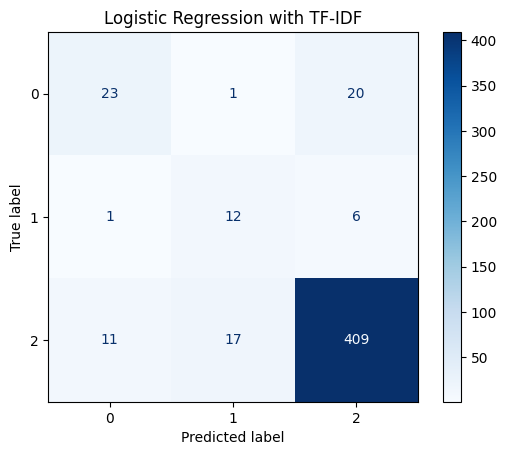

In [32]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2, "Logistic Regression with TF-IDF")

              precision    recall  f1-score   support

           0       0.66      0.52      0.58        44
           1       0.39      0.63      0.48        19
           2       0.94      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.66      0.70      0.67       500
weighted avg       0.89      0.89      0.89       500



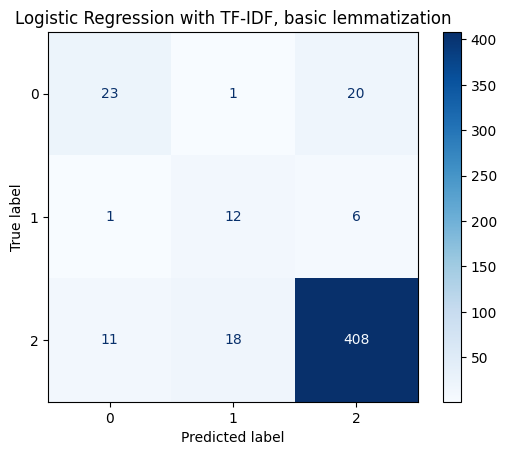

In [34]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2, "Logistic Regression with TF-IDF, basic lemmatization", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.67      0.55      0.60        44
           1       0.39      0.63      0.48        19
           2       0.94      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.70      0.67       500
weighted avg       0.90      0.89      0.89       500



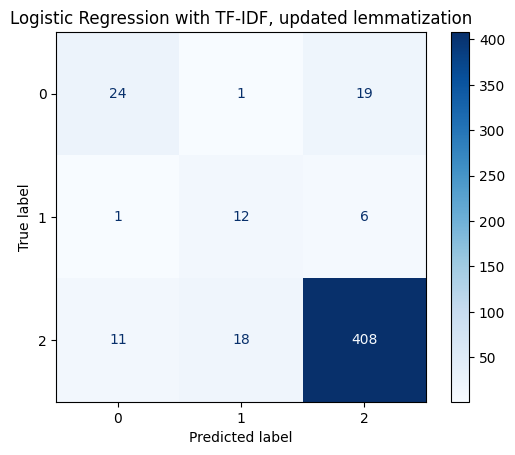

In [35]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2, "Logistic Regression with TF-IDF, updated lemmatization", lemmatizer=lemmatize_updated)

SVM regression

In [36]:
# trying different classifier

def classificationSVM(train_file, test_file, cleaner, vectorizer, title, lemmatizer = None):

    train = train_file["protein_annotation"].apply(cleaner)
    test = test_file["protein_annotation"].apply(cleaner)
    if lemmatizer:
        train = train.apply(lemmatizer)
        test = test.apply(lemmatizer)
    y_train = train_file["label"]
    y_test = test_file["label"]

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(train)
    test_vectors = vectorizer.transform(test)

    #training classifier
    clf = LinearSVC(class_weight='balanced', random_state=42)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

lets see if we can improve the SVM

In [37]:
# trying again with pipeline and grid search
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

pipe = Pipeline([
    ("vectorizer", vectorizer2),
    ("svm", LinearSVC())  # OvR multiclass by default
])

param_grid = {
    # LinearSVC hyperparams
    "svm__C": np.logspace(-4, 3, 10),
    "svm__loss": ["squared_hinge"],   # best supported
    "svm__penalty": ["l2"],
    # If you have MANY features >> samples, keep dual=True (default).
    # If samples >> features, try dual=False as well:
    # "svm__dual": [True, False],
    "svm__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1
)

grid.fit(train, y_train)
print("Best params:", grid.best_params_)
print("CV f1_macro:", grid.best_score_)
print("\nTest performance:\n", classification_report(y_val, grid.predict(val)))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'svm__C': np.float64(0.774263682681127), 'svm__class_weight': 'balanced', 'svm__loss': 'squared_hinge', 'svm__penalty': 'l2'}
CV f1_macro: 0.6886230771836247

Test performance:
               precision    recall  f1-score   support

           0       0.57      0.68      0.62        87
           1       0.43      0.64      0.52        39
           2       0.96      0.92      0.94       874

    accuracy                           0.89      1000
   macro avg       0.65      0.75      0.69      1000
weighted avg       0.91      0.89      0.90      1000



In [38]:
# optimising SVM classifier

def SVMopt(train_file, test_file, cleaner, vectorizer, title, lemmatizer = None):

    train = train_file["protein_annotation"].apply(cleaner)
    test = test_file["protein_annotation"].apply(cleaner)
    if lemmatizer:
        train = train.apply(lemmatizer)
        test = test.apply(lemmatizer)
    y_train = train_file["label"]
    y_test = test_file["label"]

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(train)
    test_vectors = vectorizer.transform(test)

    #training classifier
    clf = LinearSVC(C = 0.7743, class_weight='balanced', loss = 'squared_hinge', penalty='l2', random_state=42)
 
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.42      0.68      0.52        19
           2       0.95      0.94      0.94       437

    accuracy                           0.89       500
   macro avg       0.68      0.73      0.69       500
weighted avg       0.90      0.89      0.90       500



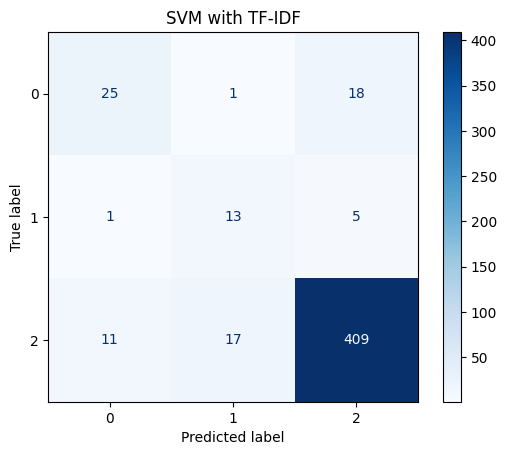

In [39]:
SVMopt(train_file, test_file, clean_text3, vectorizer2, "SVM with TF-IDF")


              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.41      0.68      0.51        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.68      0.73      0.69       500
weighted avg       0.90      0.89      0.90       500



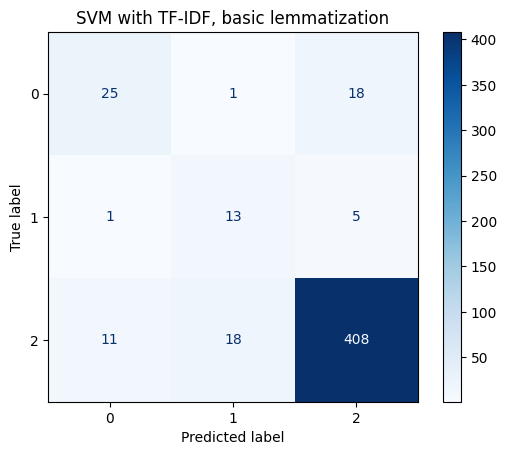

In [40]:
SVMopt(train_file, test_file, clean_text3, vectorizer2, "SVM with TF-IDF, basic lemmatization", lemmatizer=lemmatize_bio_text)


              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.39      0.68      0.50        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.73      0.69       500
weighted avg       0.90      0.89      0.89       500



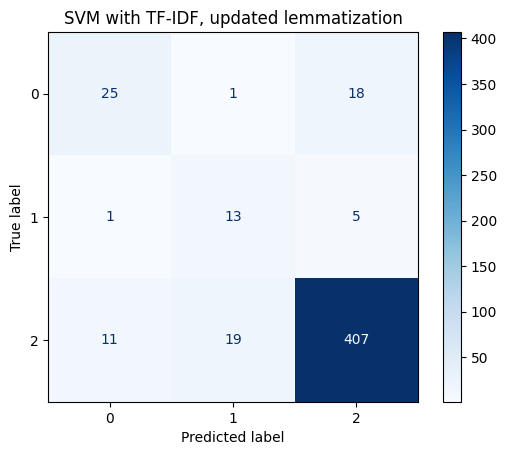

In [41]:
SVMopt(train_file, test_file, clean_text3, vectorizer2, "SVM with TF-IDF, updated lemmatization", lemmatizer=lemmatize_updated)

Trying random forest

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


pipe = Pipeline([
    ("tfidf", vectorizer2),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

param_distributions = {
    "rf__n_estimators": randint(300, 1200),
    "rf__max_depth": [10, 20, 30, 40, 50, None],
    "rf__min_samples_split": randint(2, 20),
    "rf__min_samples_leaf": randint(1, 10),
    "rf__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "rf__bootstrap": [True, False],
    "rf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=60,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(train, y_train)
print("Best params:", search.best_params_)
print("CV f1_macro:", search.best_score_)



Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best params: {'rf__bootstrap': False, 'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 18, 'rf__n_estimators': 403}
CV f1_macro: 0.5863427764598391


In [110]:
# Random forest

def RF(train_file, test_file, cleaner, vectorizer, title, lemmatizer = None):

    train = train_file["protein_annotation"].apply(cleaner)
    test = test_file["protein_annotation"].apply(cleaner)
    if lemmatizer:
        train = train.apply(lemmatizer)
        test = test.apply(lemmatizer)
    y_train = train_file["label"]
    y_test = test_file["label"]

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(train)
    test_vectors = vectorizer.transform(test)

    #training classifier
    clf = RandomForestClassifier(
        bootstrap=False,
        class_weight='balanced',
        max_depth=20,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=18,
        n_estimators=403,
        n_jobs=-1   
    )

    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

Naive Bayes

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

pipe = Pipeline([
    ("tfidf", vectorizer2),
    ("nb", MultinomialNB())
])

param_grid = {
    "nb__alpha": np.logspace(-3, 1, 10),
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(train, y_train)
print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)
print("\nTest performance:\n", classification_report(y_val, grid.predict(val)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'nb__alpha': np.float64(0.001)}
Best CV f1_macro: 0.6687674219503064

Test performance:
               precision    recall  f1-score   support

           0       0.82      0.56      0.67        87
           1       0.44      0.59      0.51        39
           2       0.95      0.96      0.95       874

    accuracy                           0.91      1000
   macro avg       0.73      0.70      0.71      1000
weighted avg       0.92      0.91      0.91      1000



In [45]:
# Multimodal Naive Bayes

def MNB(train_file, test_file, cleaner, vectorizer, title, lemmatizer = None):

    train = train_file["protein_annotation"].apply(cleaner)
    test = test_file["protein_annotation"].apply(cleaner)
    if lemmatizer:
        train = train.apply(lemmatizer)
        test = test.apply(lemmatizer)
    y_train = train_file["label"]
    y_test = test_file["label"]

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(train)
    test_vectors = vectorizer.transform(test)

    #training classifier
    clf = MultinomialNB(alpha=0.001)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

In [46]:
from sklearn.naive_bayes import ComplementNB

pipe = Pipeline([
    ("tfidf", vectorizer2),
    ("cnb", ComplementNB())
])
param_grid = {
    "cnb__alpha": np.logspace(-3, 1, 10),
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(train, y_train)
print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)
print("\nTest performance:\n", classification_report(y_val, grid.predict(val)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'cnb__alpha': np.float64(0.0027825594022071257)}
Best CV f1_macro: 0.7067426442665179

Test performance:
               precision    recall  f1-score   support

           0       0.51      0.83      0.63        87
           1       0.38      0.74      0.50        39
           2       0.98      0.88      0.93       874

    accuracy                           0.87      1000
   macro avg       0.63      0.82      0.69      1000
weighted avg       0.92      0.87      0.89      1000



In [47]:
# Complement Naive Bayes

def CNB(train_file, test_file, cleaner, vectorizer, title, lemmatizer = None):

    train = train_file["protein_annotation"].apply(cleaner)
    test = test_file["protein_annotation"].apply(cleaner)
    if lemmatizer:
        train = train.apply(lemmatizer)
        test = test.apply(lemmatizer)
    y_train = train_file["label"]
    y_test = test_file["label"]

    # building vectorizer on train set and transforming both train and test
    train_vectors = vectorizer.fit_transform(train)
    test_vectors = vectorizer.transform(test)

    #training classifier
    clf = ComplementNB(alpha=0.002783)
    clf.fit(train_vectors, y_train)

    y_pred = clf.predict(test_vectors)
    print(classification_report(y_test, y_pred))    

    class_names = clf.classes_
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')  # 'd' = integer format
    plt.title(title)
    plt.show()

Classifier accuracy tests

              precision    recall  f1-score   support

           0       0.93      0.30      0.45        44
           1       1.00      0.05      0.10        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.94      0.45      0.50       500
weighted avg       0.91      0.90      0.87       500



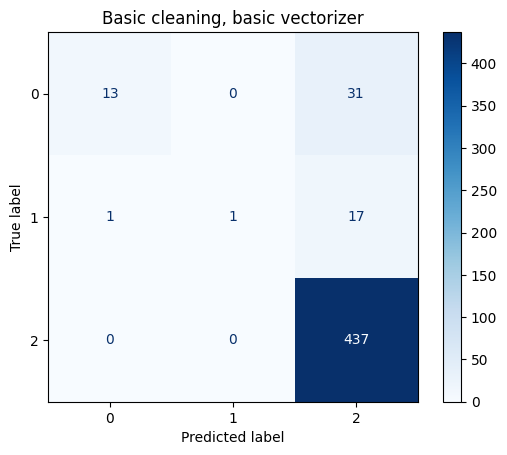

In [48]:
classification_test(train_file, test_file, clean_text_basic, vectorizer_basic, "Basic cleaning, basic vectorizer")

              precision    recall  f1-score   support

           0       0.93      0.30      0.45        44
           1       1.00      0.05      0.10        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.94      0.45      0.50       500
weighted avg       0.91      0.90      0.87       500



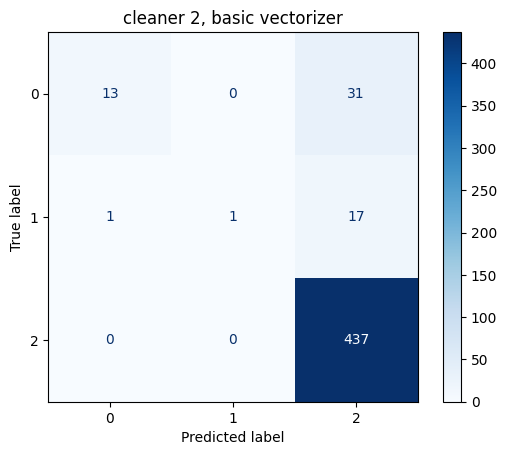

In [49]:
classification_test(train_file, test_file, clean_text2, vectorizer_basic, "cleaner 2, basic vectorizer")

              precision    recall  f1-score   support

           0       0.86      0.27      0.41        44
           1       0.22      0.58      0.32        19
           2       0.93      0.93      0.93       437

    accuracy                           0.86       500
   macro avg       0.67      0.59      0.55       500
weighted avg       0.90      0.86      0.86       500



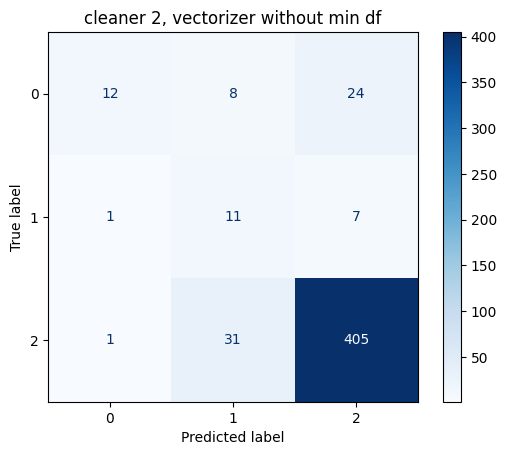

In [50]:
classification_test(train_file, test_file, clean_text2, vectorizer2, "cleaner 2, vectorizer without min df")

              precision    recall  f1-score   support

           0       0.63      0.43      0.51        44
           1       0.29      0.53      0.37        19
           2       0.93      0.92      0.93       437

    accuracy                           0.87       500
   macro avg       0.62      0.63      0.60       500
weighted avg       0.88      0.87      0.87       500



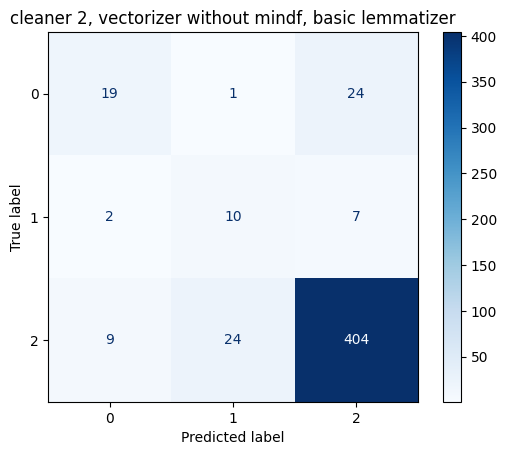

In [51]:
classification_test(train_file, test_file, clean_text2, vectorizer2, "cleaner 2, vectorizer without mindf, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.63      0.43      0.51        44
           1       0.40      0.11      0.17        19
           2       0.91      0.97      0.94       437

    accuracy                           0.89       500
   macro avg       0.65      0.50      0.54       500
weighted avg       0.87      0.89      0.88       500



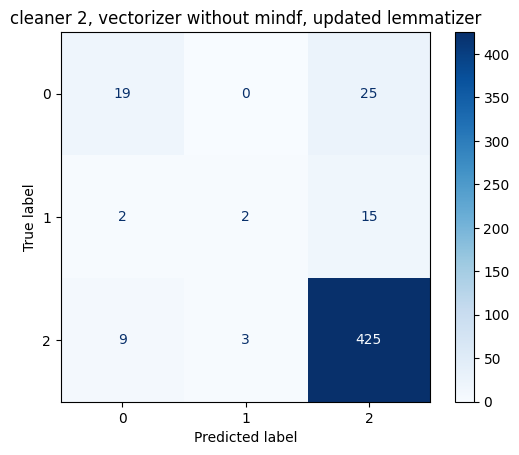

In [52]:
classification_test(train_file, test_file, clean_text2, vectorizer2, "cleaner 2, vectorizer without mindf, updated lemmatizer", lemmatize_updated)

              precision    recall  f1-score   support

           0       0.86      0.27      0.41        44
           1       0.25      0.53      0.34        19
           2       0.93      0.95      0.94       437

    accuracy                           0.87       500
   macro avg       0.68      0.58      0.56       500
weighted avg       0.89      0.87      0.87       500



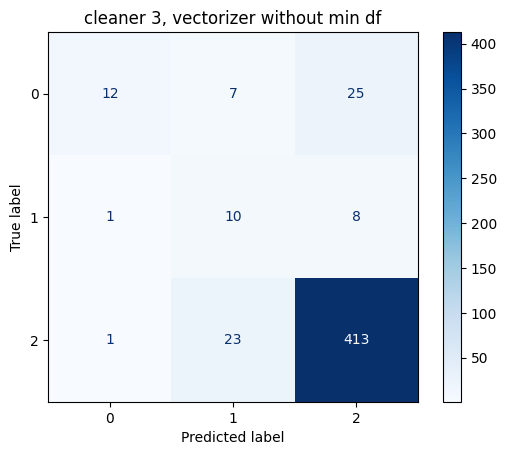

In [53]:
classification_test(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer without min df")

              precision    recall  f1-score   support

           0       0.86      0.27      0.41        44
           1       0.24      0.53      0.33        19
           2       0.93      0.94      0.93       437

    accuracy                           0.87       500
   macro avg       0.68      0.58      0.56       500
weighted avg       0.89      0.87      0.87       500



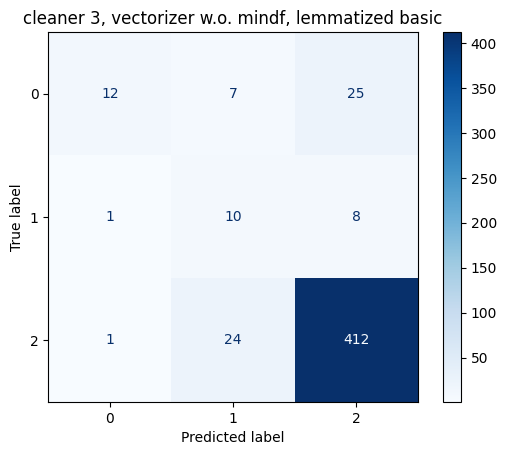

In [54]:
classification_test(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. mindf, lemmatized basic", lemmatizer=lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.86      0.27      0.41        44
           1       0.24      0.53      0.33        19
           2       0.93      0.94      0.93       437

    accuracy                           0.87       500
   macro avg       0.68      0.58      0.56       500
weighted avg       0.89      0.87      0.87       500



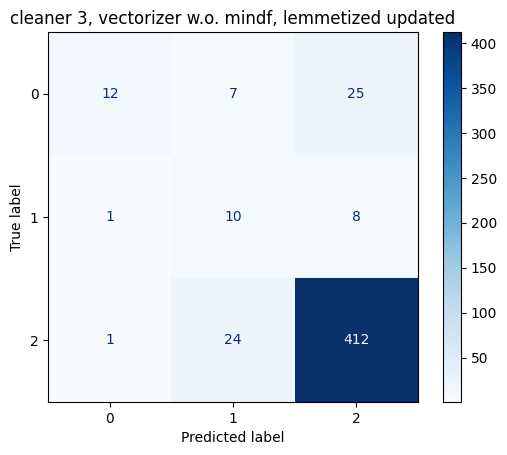

In [55]:
classification_test(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. mindf, lemmetized updated", lemmatizer=lemmatize_updated)

              precision    recall  f1-score   support

           0       0.63      0.43      0.51        44
           1       0.29      0.53      0.37        19
           2       0.93      0.92      0.93       437

    accuracy                           0.87       500
   macro avg       0.62      0.63      0.60       500
weighted avg       0.88      0.87      0.87       500



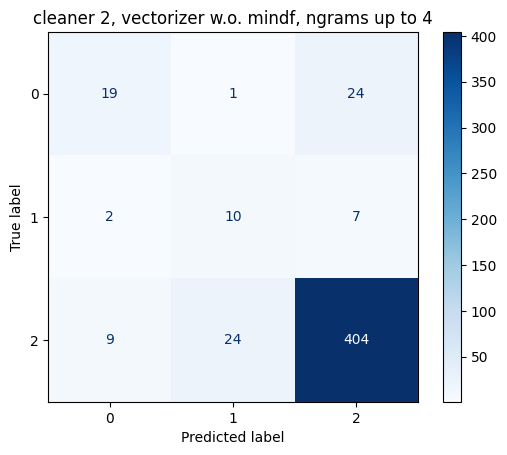

In [56]:
classification_test(train_file, test_file, clean_text2, vectorizer2_5, "cleaner 2, vectorizer w.o. mindf, ngrams up to 4")

              precision    recall  f1-score   support

           0       0.64      0.41      0.50        44
           1       0.32      0.53      0.40        19
           2       0.93      0.93      0.93       437

    accuracy                           0.87       500
   macro avg       0.63      0.62      0.61       500
weighted avg       0.88      0.87      0.87       500



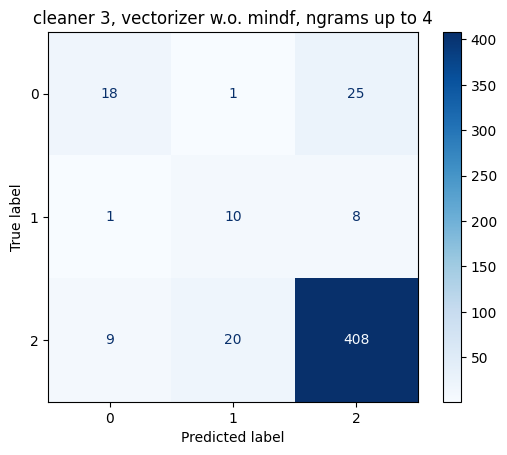

In [57]:
classification_test(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. mindf, ngrams up to 4")

              precision    recall  f1-score   support

           0       0.64      0.41      0.50        44
           1       0.32      0.53      0.40        19
           2       0.93      0.93      0.93       437

    accuracy                           0.87       500
   macro avg       0.63      0.62      0.61       500
weighted avg       0.88      0.87      0.87       500



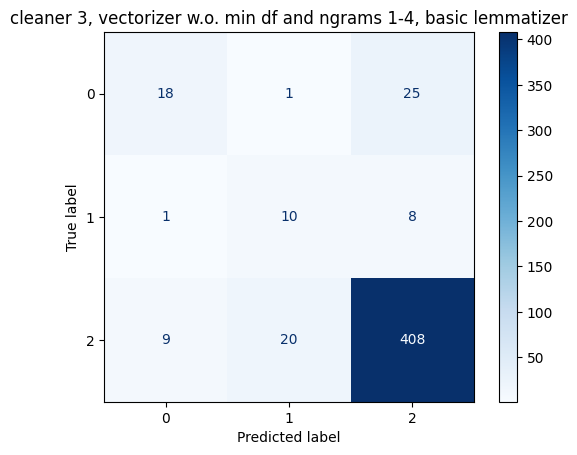

In [58]:
classification_test(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams 1-4, basic lemmatizer", lemmatizer=lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.64      0.41      0.50        44
           1       0.33      0.53      0.41        19
           2       0.93      0.94      0.93       437

    accuracy                           0.87       500
   macro avg       0.63      0.62      0.61       500
weighted avg       0.88      0.87      0.87       500



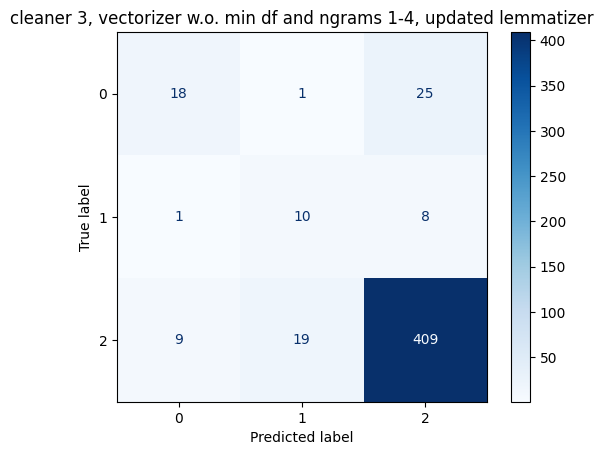

In [59]:
classification_test(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams 1-4, updated lemmatizer", lemmatizer=lemmatize_updated)

c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.93      0.30      0.45        44
           1       0.00      0.00      0.00        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.61      0.43      0.47       500
weighted avg       0.87      0.90      0.87       500



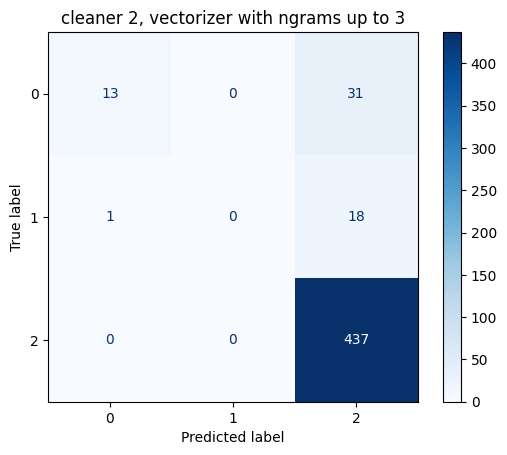

In [60]:
classification_test(train_file, test_file, clean_text2, vectorizer3, "cleaner 2, vectorizer with ngrams up to 3")

c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.93      0.30      0.45        44
           1       0.00      0.00      0.00        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.61      0.43      0.47       500
weighted avg       0.87      0.90      0.87       500



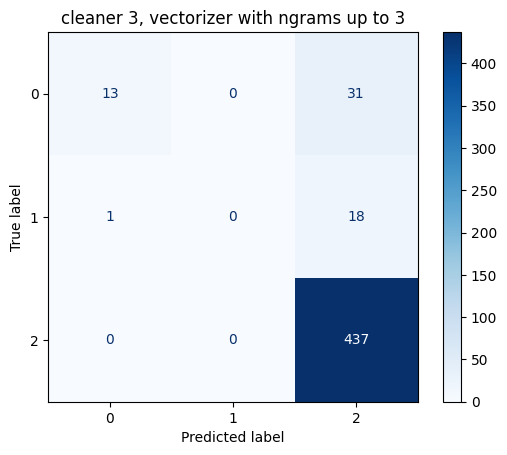

In [61]:
classification_test(train_file, test_file, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3")

              precision    recall  f1-score   support

           0       0.92      0.27      0.42        44
           1       1.00      0.05      0.10        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.94      0.44      0.49       500
weighted avg       0.91      0.90      0.87       500



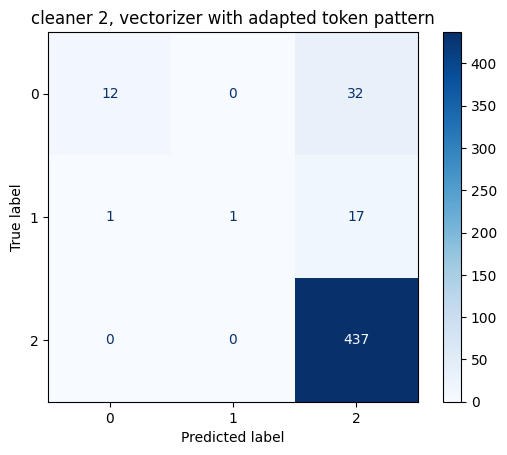

In [62]:
classification_test(train_file, test_file, clean_text2, vectorizer4, "cleaner 2, vectorizer with adapted token pattern")

c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caraj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.92      0.27      0.42        44
           1       0.00      0.00      0.00        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.61      0.42      0.46       500
weighted avg       0.87      0.90      0.86       500



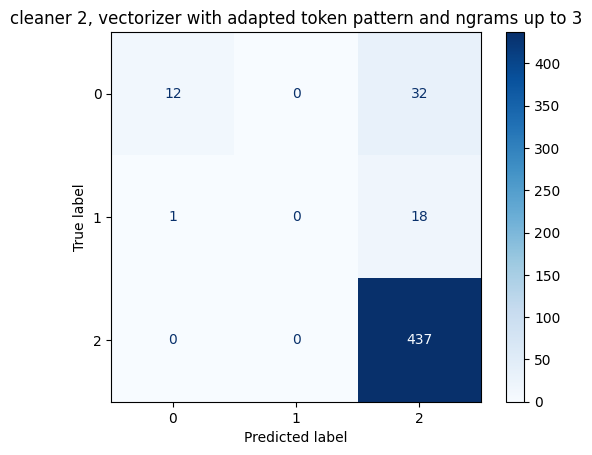

In [63]:
classification_test(train_file, test_file, clean_text2, vectorizer5, "cleaner 2, vectorizer with adapted token pattern and ngrams up to 3")

              precision    recall  f1-score   support

           0       0.93      0.30      0.45        44
           1       1.00      0.05      0.10        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.94      0.45      0.50       500
weighted avg       0.91      0.90      0.87       500



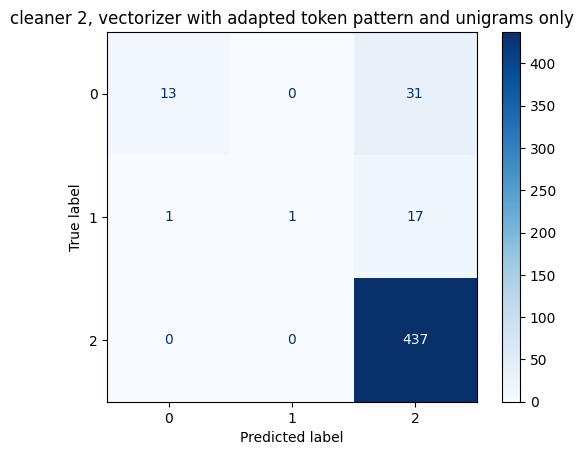

In [64]:
classification_test(train_file, test_file, clean_text2, vectorizer6, "cleaner 2, vectorizer with adapted token pattern and unigrams only")

              precision    recall  f1-score   support

           0       0.93      0.32      0.47        44
           1       1.00      0.05      0.10        19
           2       0.90      1.00      0.95       437

    accuracy                           0.90       500
   macro avg       0.95      0.46      0.51       500
weighted avg       0.91      0.90      0.87       500



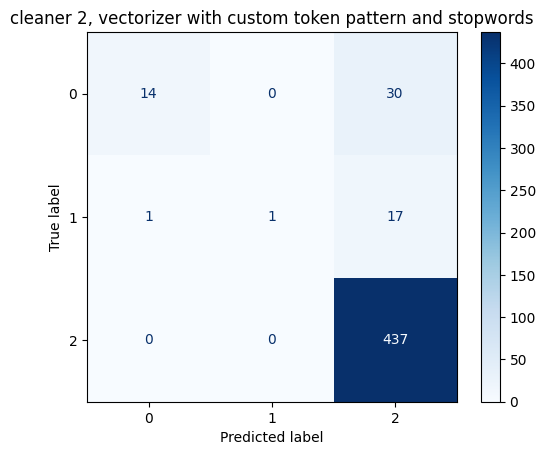

In [65]:
classification_test(train_file, test_file, clean_text2, vectorizer7, "cleaner 2, vectorizer with custom token pattern and stopwords")

              precision    recall  f1-score   support

           0       0.86      0.27      0.41        44
           1       0.18      0.58      0.28        19
           2       0.93      0.90      0.92       437

    accuracy                           0.84       500
   macro avg       0.66      0.59      0.54       500
weighted avg       0.89      0.84      0.85       500



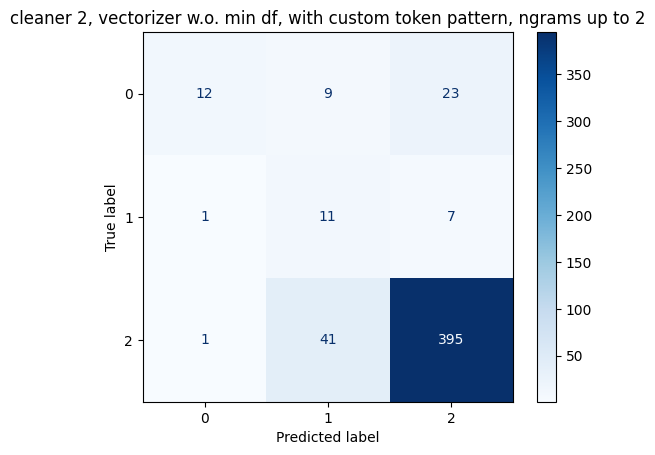

In [66]:
classification_test(train_file, test_file, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. min df, with custom token pattern, ngrams up to 2")

              precision    recall  f1-score   support

           0       0.65      0.45      0.53        44
           1       0.29      0.53      0.37        19
           2       0.93      0.92      0.93       437

    accuracy                           0.87       500
   macro avg       0.62      0.64      0.61       500
weighted avg       0.88      0.87      0.87       500



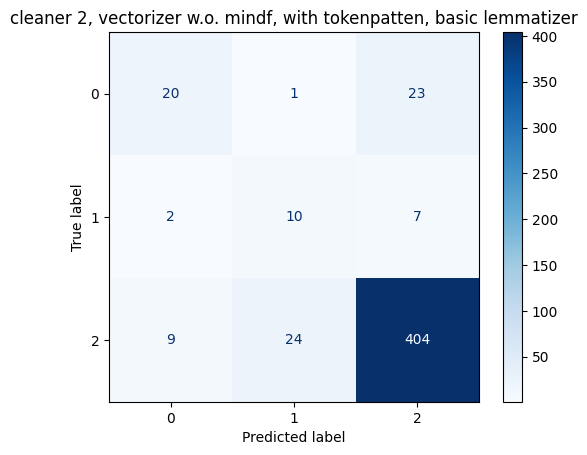

In [67]:
classification_test(train_file, test_file, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. mindf, with tokenpatten, basic lemmatizer",lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.63      0.43      0.51        44
           1       0.40      0.11      0.17        19
           2       0.91      0.97      0.94       437

    accuracy                           0.89       500
   macro avg       0.65      0.50      0.54       500
weighted avg       0.87      0.89      0.88       500



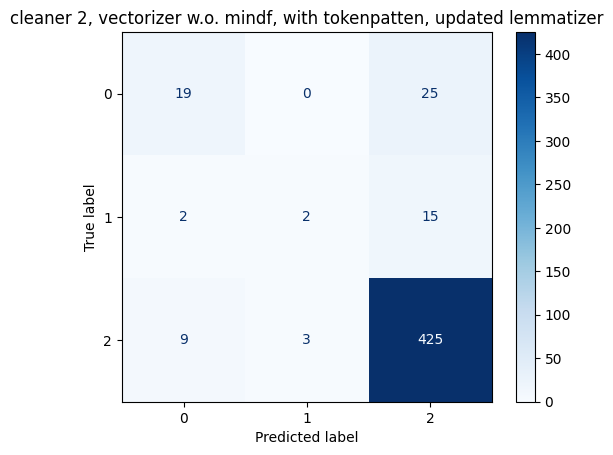

In [68]:
classification_test(train_file, test_file, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. mindf, with tokenpatten, updated lemmatizer",lemmatize_updated)

              precision    recall  f1-score   support

           0       0.86      0.27      0.41        44
           1       0.17      0.53      0.25        19
           2       0.93      0.90      0.92       437

    accuracy                           0.83       500
   macro avg       0.65      0.57      0.53       500
weighted avg       0.89      0.83      0.85       500



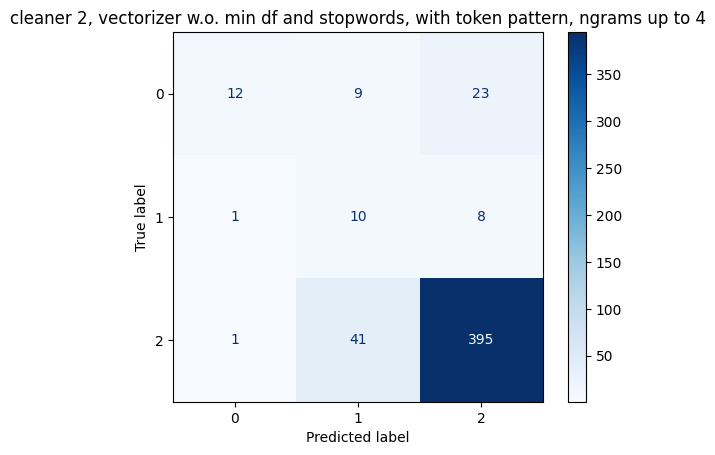

In [69]:
classification_test(train_file, test_file, clean_text2, vectorizer9, "cleaner 2, vectorizer w.o. min df and stopwords, with token pattern, ngrams up to 4")

Optimised Logistic model

               precision    recall  f1-score   support

          low       0.47      0.56      0.51        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.59      0.58        87

     accuracy                           0.89      1000
    macro avg       0.66      0.70      0.68      1000
 weighted avg       0.90      0.89      0.90      1000



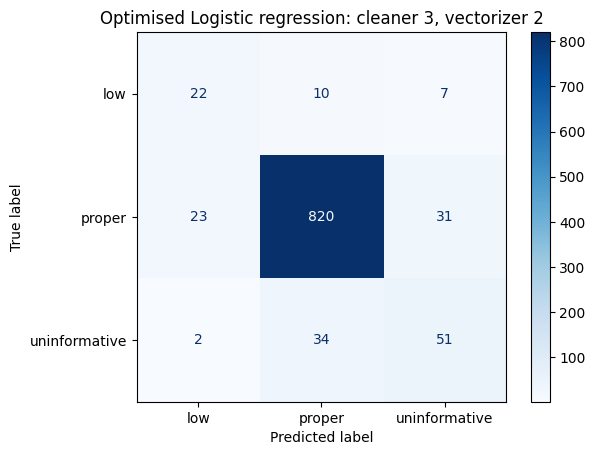

In [ ]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2, "Optimised Logistic regression: cleaner 3, vectorizer 2")

               precision    recall  f1-score   support

          low       0.47      0.56      0.51        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.59      0.58        87

     accuracy                           0.89      1000
    macro avg       0.66      0.70      0.68      1000
 weighted avg       0.90      0.89      0.90      1000



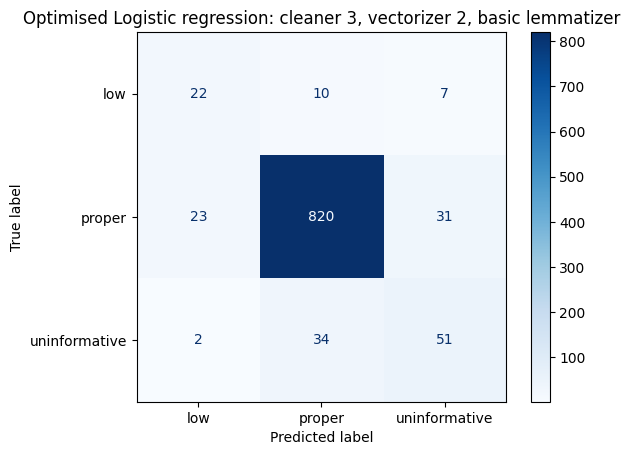

In [ ]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2, "Optimised Logistic regression: cleaner 3, vectorizer 2, basic lemmatizer", lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.48      0.59      0.53        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.89      1000
    macro avg       0.67      0.71      0.69      1000
 weighted avg       0.90      0.89      0.90      1000



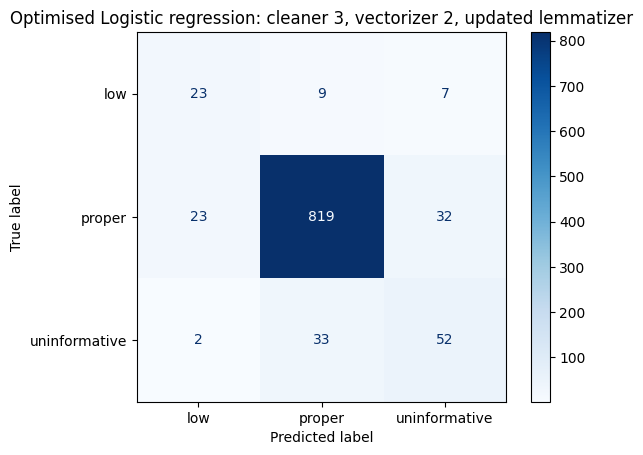

In [ ]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2, "Optimised Logistic regression: cleaner 3, vectorizer 2, updated lemmatizer", lemmatize_updated)

              precision    recall  f1-score   support

           0       0.65      0.50      0.56        44
           1       0.38      0.58      0.46        19
           2       0.94      0.94      0.94       437

    accuracy                           0.88       500
   macro avg       0.65      0.67      0.65       500
weighted avg       0.89      0.88      0.89       500



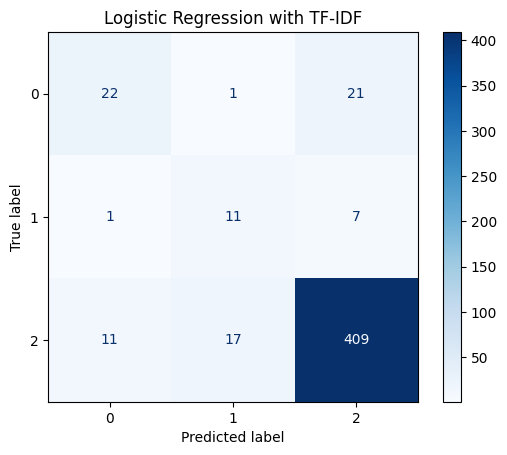

In [70]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2_5, "Logistic Regression with TF-IDF")

              precision    recall  f1-score   support

           0       0.65      0.50      0.56        44
           1       0.35      0.58      0.44        19
           2       0.94      0.93      0.93       437

    accuracy                           0.88       500
   macro avg       0.65      0.67      0.65       500
weighted avg       0.89      0.88      0.88       500



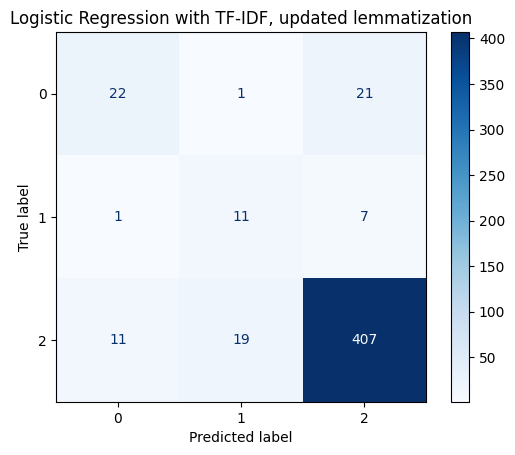

In [71]:
logistic_opt(train_file, test_file, clean_text3, vectorizer2_5, "Logistic Regression with TF-IDF, updated lemmatization", lemmatizer=lemmatize_updated)

              precision    recall  f1-score   support

           0       0.53      0.55      0.54        44
           1       0.30      0.58      0.39        19
           2       0.94      0.90      0.92       437

    accuracy                           0.86       500
   macro avg       0.59      0.67      0.62       500
weighted avg       0.88      0.86      0.87       500



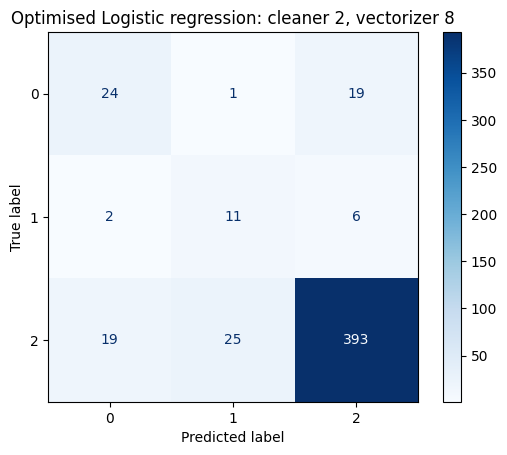

In [72]:
logistic_opt(train_file, test_file, clean_text2, vectorizer8, "Optimised Logistic regression: cleaner 2, vectorizer 8")

              precision    recall  f1-score   support

           0       0.65      0.55      0.59        44
           1       0.31      0.63      0.41        19
           2       0.94      0.92      0.93       437

    accuracy                           0.87       500
   macro avg       0.63      0.70      0.65       500
weighted avg       0.89      0.87      0.88       500



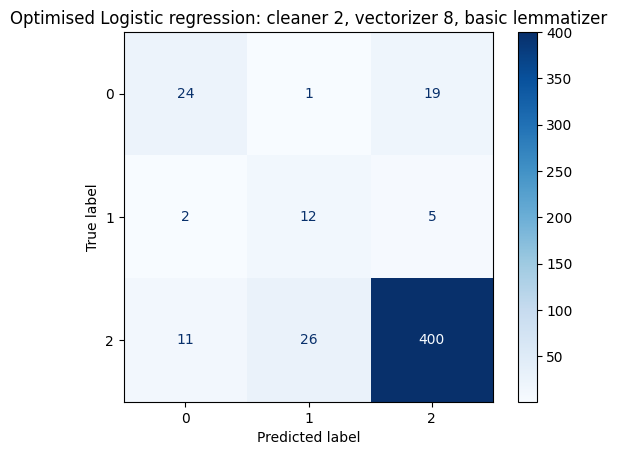

In [73]:
logistic_opt(train_file, test_file, clean_text2, vectorizer8, "Optimised Logistic regression: cleaner 2, vectorizer 8, basic lemmatizer", lemmatize_bio_text)

SVM regression

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        44
           1       0.42      0.26      0.32        19
           2       0.93      0.96      0.94       437

    accuracy                           0.90       500
   macro avg       0.67      0.60      0.63       500
weighted avg       0.89      0.90      0.89       500



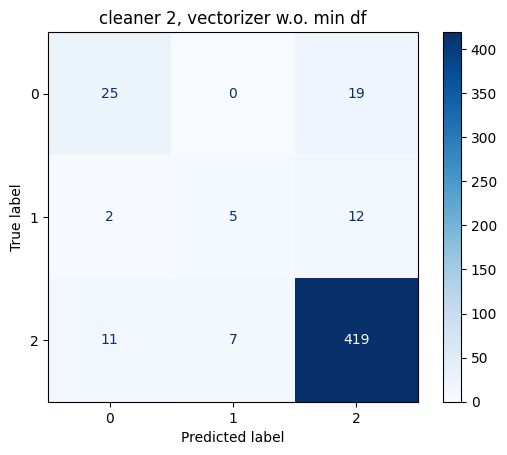

In [74]:
classificationSVM(train_file, test_file, clean_text2, vectorizer2, "cleaner 2, vectorizer w.o. min df")

              precision    recall  f1-score   support

           0       0.68      0.59      0.63        44
           1       0.42      0.68      0.52        19
           2       0.95      0.94      0.94       437

    accuracy                           0.90       500
   macro avg       0.68      0.74      0.70       500
weighted avg       0.91      0.90      0.90       500



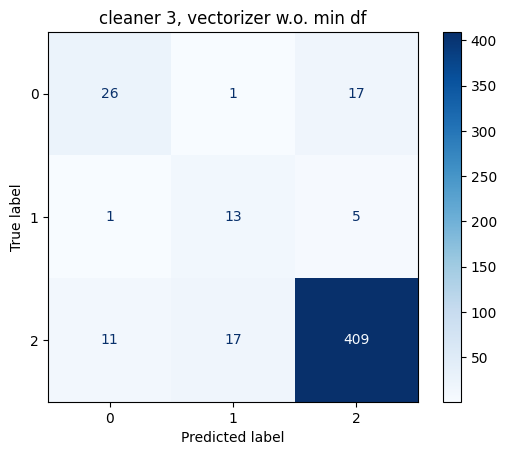

In [75]:
classificationSVM(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.41      0.68      0.51        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.68      0.73      0.69       500
weighted avg       0.90      0.89      0.90       500



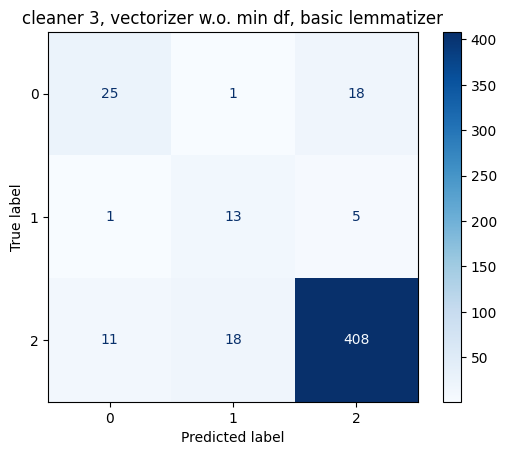

In [76]:
classificationSVM(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer",lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.68      0.59      0.63        44
           1       0.39      0.68      0.50        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.68      0.74      0.69       500
weighted avg       0.90      0.89      0.90       500



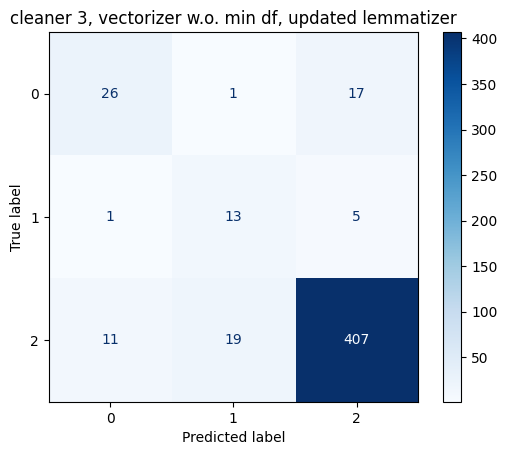

In [77]:
classificationSVM(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer",lemmatize_updated)

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        44
           1       0.33      0.68      0.44        19
           2       0.95      0.92      0.93       437

    accuracy                           0.88       500
   macro avg       0.64      0.72      0.66       500
weighted avg       0.90      0.88      0.88       500



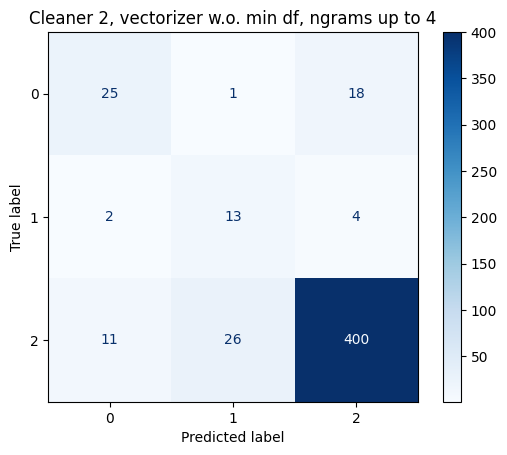

In [78]:
classificationSVM(train_file, test_file, clean_text2, vectorizer2_5, "Cleaner 2, vectorizer w.o. min df, ngrams up to 4")

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        44
           1       0.32      0.68      0.43        19
           2       0.95      0.91      0.93       437

    accuracy                           0.87       500
   macro avg       0.64      0.72      0.66       500
weighted avg       0.90      0.87      0.88       500



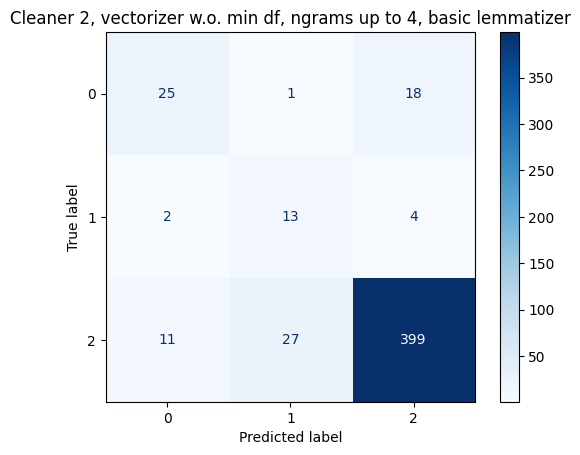

In [79]:
classificationSVM(train_file, test_file, clean_text2, vectorizer2_5, "Cleaner 2, vectorizer w.o. min df, ngrams up to 4, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        44
           1       0.50      0.26      0.34        19
           2       0.93      0.96      0.95       437

    accuracy                           0.90       500
   macro avg       0.70      0.60      0.63       500
weighted avg       0.89      0.90      0.89       500



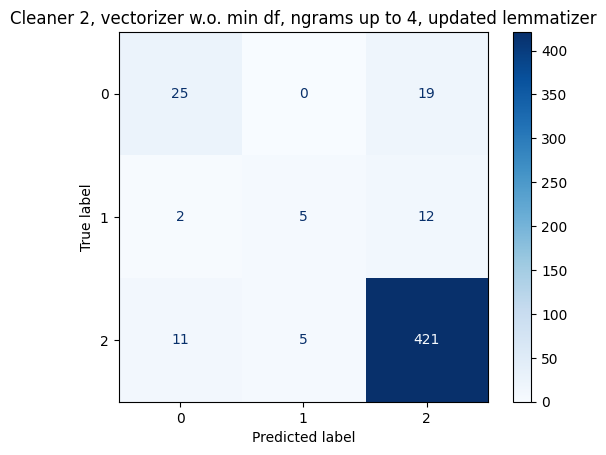

In [80]:
classificationSVM(train_file, test_file, clean_text2, vectorizer2_5, "Cleaner 2, vectorizer w.o. min df, ngrams up to 4, updated lemmatizer", lemmatize_updated)

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        44
           1       0.41      0.68      0.51        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.73      0.69       500
weighted avg       0.90      0.89      0.89       500



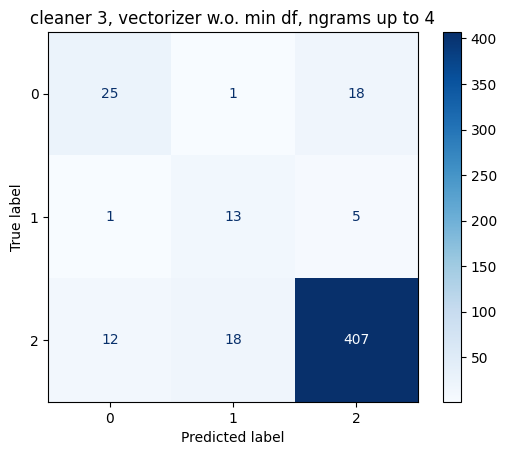

In [81]:
classificationSVM(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df, ngrams up to 4")

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        44
           1       0.39      0.68      0.50        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.73      0.68       500
weighted avg       0.90      0.89      0.89       500



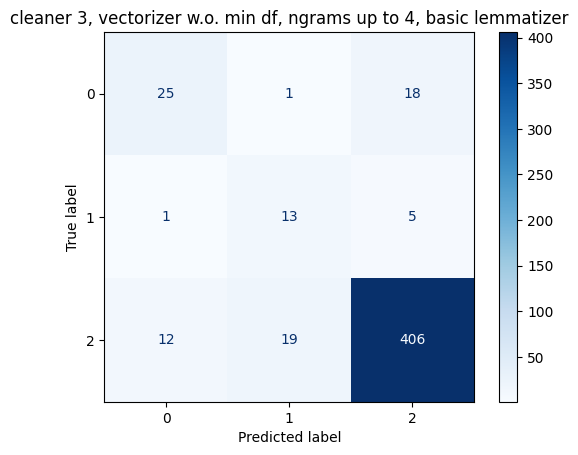

In [82]:
classificationSVM(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df, ngrams up to 4, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.39      0.68      0.50        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.73      0.69       500
weighted avg       0.90      0.89      0.89       500



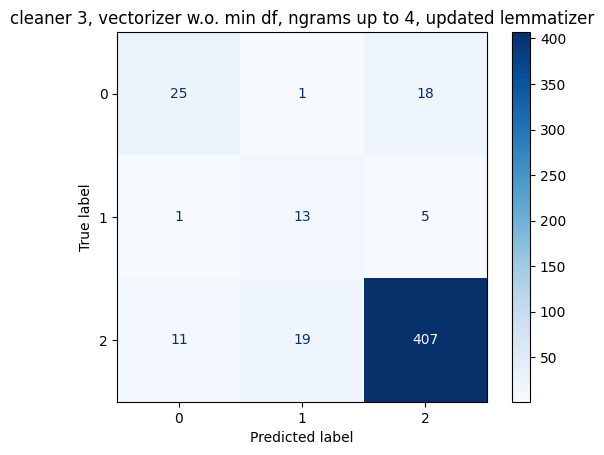

In [83]:
classificationSVM(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df, ngrams up to 4, updated lemmatizer", lemmatize_updated)

              precision    recall  f1-score   support

           0       0.51      0.55      0.53        44
           1       0.29      0.58      0.39        19
           2       0.94      0.89      0.92       437

    accuracy                           0.85       500
   macro avg       0.58      0.67      0.61       500
weighted avg       0.88      0.85      0.86       500



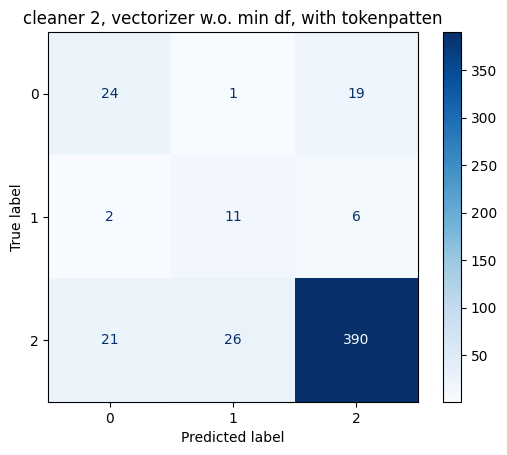

In [84]:
classificationSVM(train_file, test_file, clean_text2, vectorizer8, "cleaner 2, vectorizer w.o. min df, with tokenpatten")

              precision    recall  f1-score   support

           0       0.77      0.39      0.52        44
           1       0.28      0.58      0.37        19
           2       0.92      0.93      0.93       437

    accuracy                           0.87       500
   macro avg       0.66      0.63      0.60       500
weighted avg       0.89      0.87      0.87       500



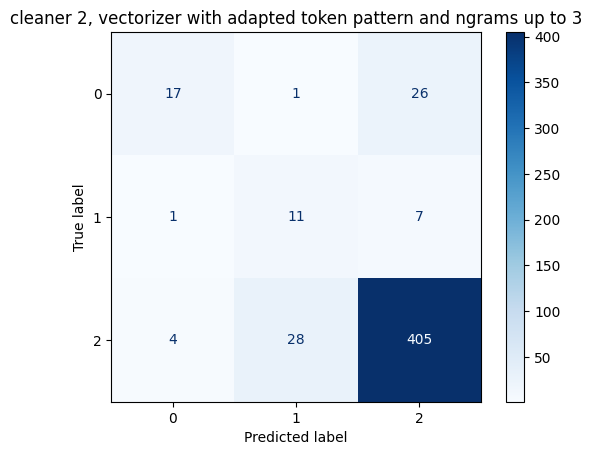

In [85]:
classificationSVM(train_file, test_file, clean_text2, vectorizer5, "cleaner 2, vectorizer with adapted token pattern and ngrams up to 3")

              precision    recall  f1-score   support

           0       0.52      0.55      0.53        44
           1       0.28      0.58      0.38        19
           2       0.94      0.89      0.92       437

    accuracy                           0.85       500
   macro avg       0.58      0.67      0.61       500
weighted avg       0.88      0.85      0.86       500



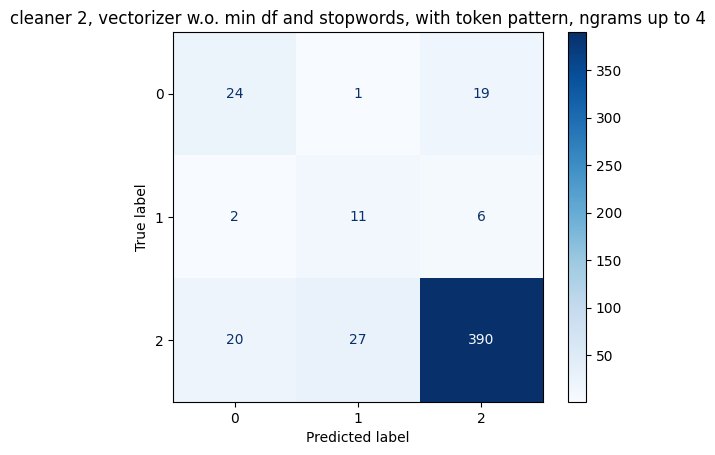

In [86]:
classificationSVM(train_file, test_file, clean_text2, vectorizer9, "cleaner 2, vectorizer w.o. min df and stopwords, with token pattern, ngrams up to 4")

              precision    recall  f1-score   support

           0       0.80      0.36      0.50        44
           1       0.33      0.68      0.45        19
           2       0.93      0.94      0.93       437

    accuracy                           0.88       500
   macro avg       0.69      0.66      0.63       500
weighted avg       0.90      0.88      0.88       500



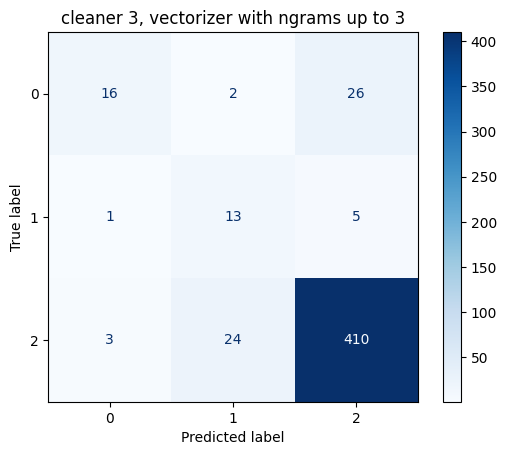

In [87]:
classificationSVM(train_file, test_file, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3")

              precision    recall  f1-score   support

           0       0.80      0.36      0.50        44
           1       0.34      0.74      0.47        19
           2       0.93      0.94      0.93       437

    accuracy                           0.88       500
   macro avg       0.69      0.68      0.63       500
weighted avg       0.90      0.88      0.88       500



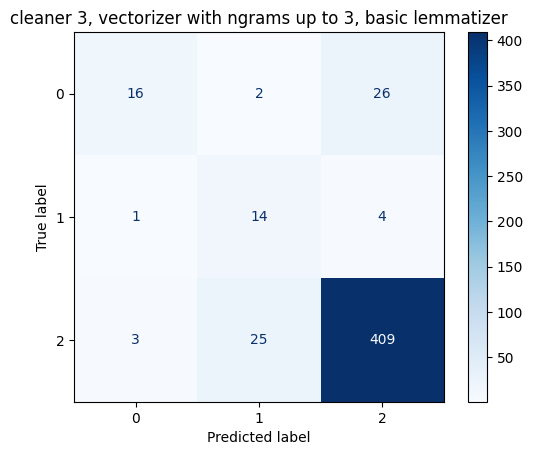

In [88]:
classificationSVM(train_file, test_file, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.81      0.39      0.52        44
           1       0.33      0.74      0.45        19
           2       0.93      0.93      0.93       437

    accuracy                           0.88       500
   macro avg       0.69      0.68      0.64       500
weighted avg       0.90      0.88      0.88       500



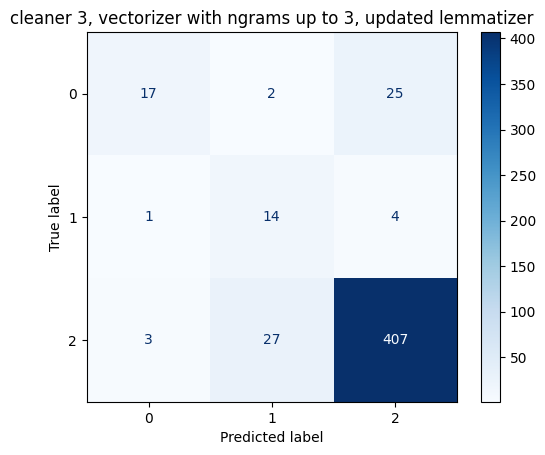

In [89]:
classificationSVM(train_file, test_file, clean_text3, vectorizer3, "cleaner 3, vectorizer with ngrams up to 3, updated lemmatizer", lemmatize_updated)

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        44
           1       0.28      0.58      0.37        19
           2       0.93      0.93      0.93       437

    accuracy                           0.87       500
   macro avg       0.66      0.64      0.61       500
weighted avg       0.89      0.87      0.87       500



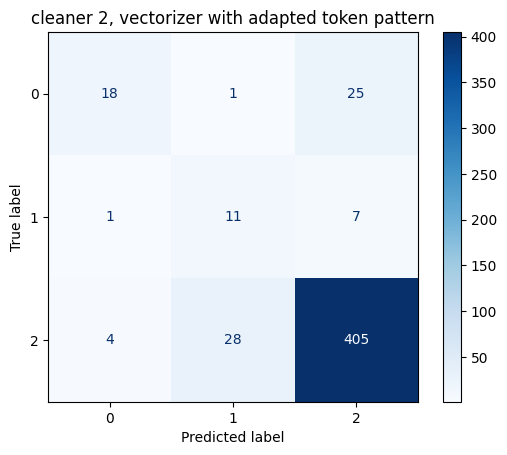

In [90]:
classificationSVM(train_file, test_file, clean_text2, vectorizer4, "cleaner 2, vectorizer with adapted token pattern")

              precision    recall  f1-score   support

           0       0.60      0.57      0.58        44
           1       0.29      0.74      0.42        19
           2       0.95      0.89      0.92       437

    accuracy                           0.86       500
   macro avg       0.61      0.73      0.64       500
weighted avg       0.89      0.86      0.87       500



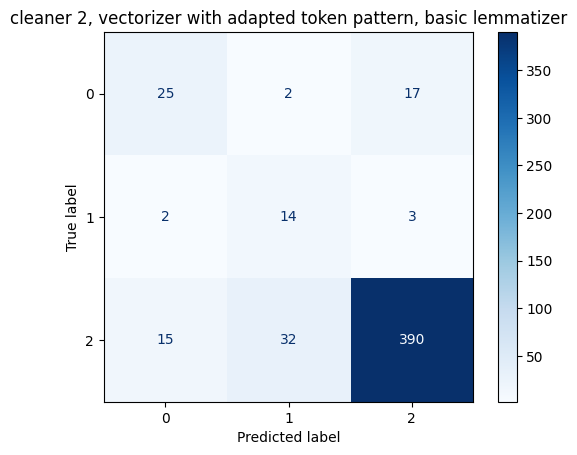

In [91]:
classificationSVM(train_file, test_file, clean_text2, vectorizer4, "cleaner 2, vectorizer with adapted token pattern, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        44
           1       0.27      0.63      0.38        19
           2       0.93      0.92      0.92       437

    accuracy                           0.86       500
   macro avg       0.66      0.65      0.61       500
weighted avg       0.89      0.86      0.87       500



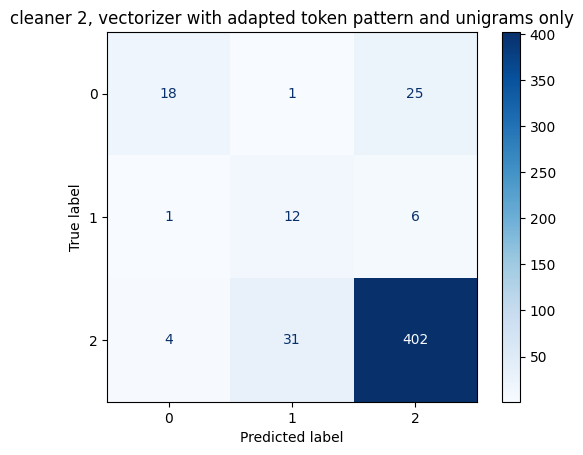

In [92]:
classificationSVM(train_file, test_file, clean_text2, vectorizer6, "cleaner 2, vectorizer with adapted token pattern and unigrams only")

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        44
           1       0.28      0.58      0.38        19
           2       0.93      0.93      0.93       437

    accuracy                           0.87       500
   macro avg       0.66      0.64      0.61       500
weighted avg       0.89      0.87      0.87       500



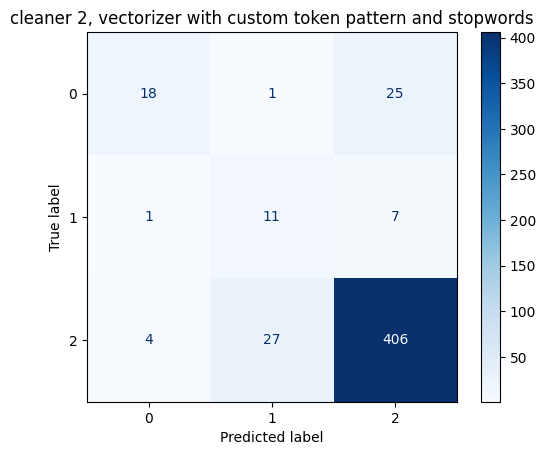

In [93]:
classificationSVM(train_file, test_file, clean_text2, vectorizer7, "cleaner 2, vectorizer with custom token pattern and stopwords")

Optimised SVM

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



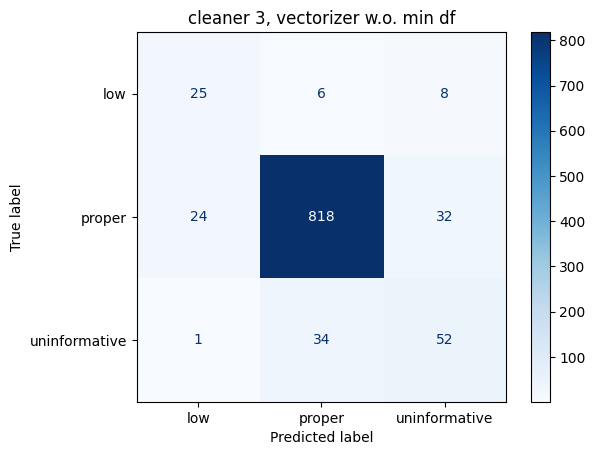

In [ ]:
SVMopt(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.94      0.94       874
uninformative       0.57      0.60      0.58        87

     accuracy                           0.90      1000
    macro avg       0.67      0.72      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



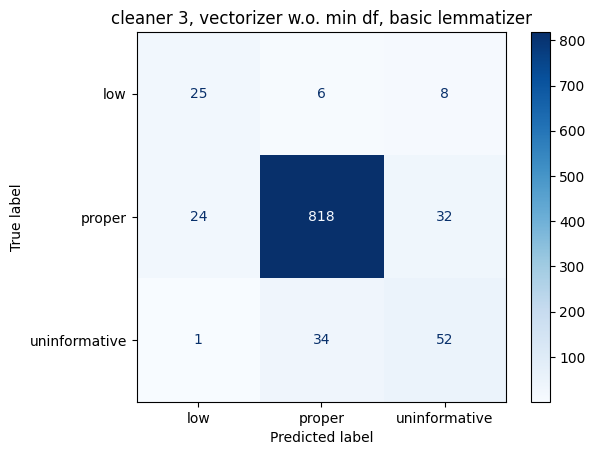

In [ ]:
SVMopt(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer",lemmatize_bio_text)

               precision    recall  f1-score   support

          low       0.50      0.64      0.56        39
       proper       0.95      0.93      0.94       874
uninformative       0.56      0.61      0.59        87

     accuracy                           0.90      1000
    macro avg       0.67      0.73      0.70      1000
 weighted avg       0.90      0.90      0.90      1000



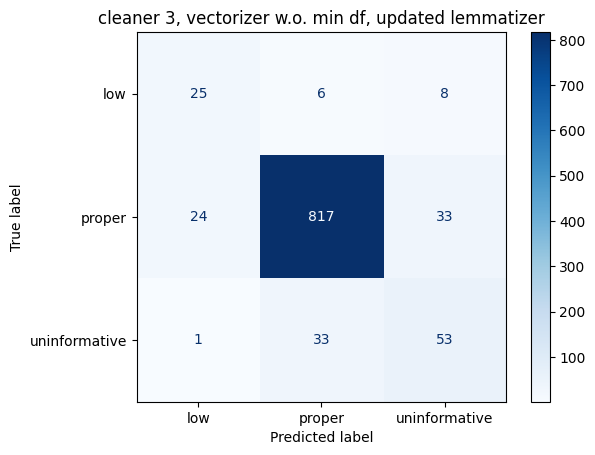

In [ ]:
SVMopt(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer",lemmatize_updated)

              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.41      0.68      0.51        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.68      0.73      0.69       500
weighted avg       0.90      0.89      0.90       500



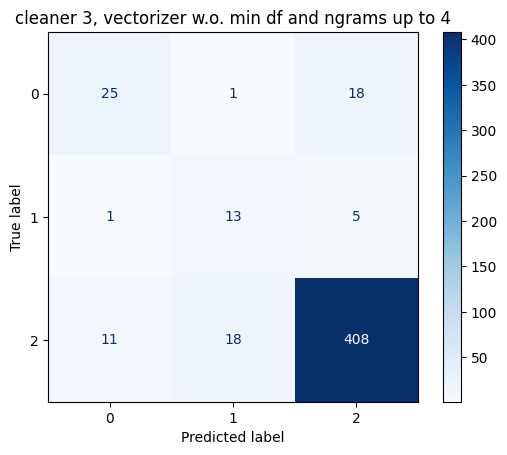

In [94]:
SVMopt(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams up to 4")

              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.39      0.68      0.50        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.73      0.69       500
weighted avg       0.90      0.89      0.89       500



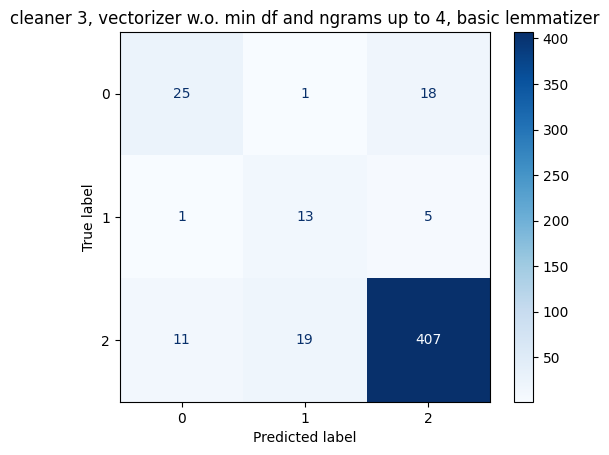

In [95]:
SVMopt(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams up to 4, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.39      0.68      0.50        19
           2       0.95      0.93      0.94       437

    accuracy                           0.89       500
   macro avg       0.67      0.73      0.69       500
weighted avg       0.90      0.89      0.89       500



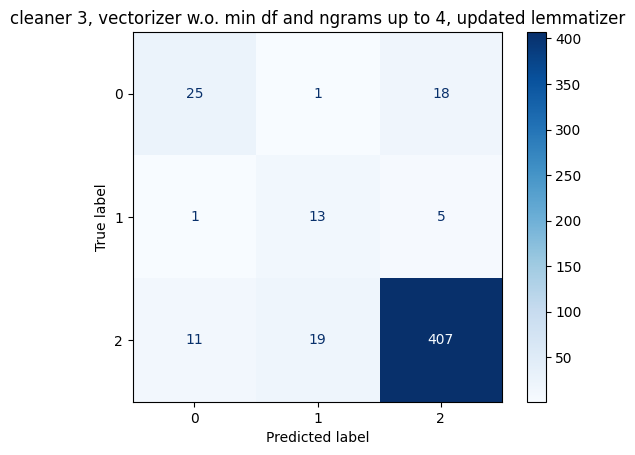

In [96]:
SVMopt(train_file, test_file, clean_text3, vectorizer2_5, "cleaner 3, vectorizer w.o. min df and ngrams up to 4, updated lemmatizer", lemmatize_updated)

              precision    recall  f1-score   support

           0       0.77      0.39      0.52        44
           1       0.28      0.58      0.37        19
           2       0.92      0.93      0.93       437

    accuracy                           0.87       500
   macro avg       0.66      0.63      0.60       500
weighted avg       0.89      0.87      0.87       500



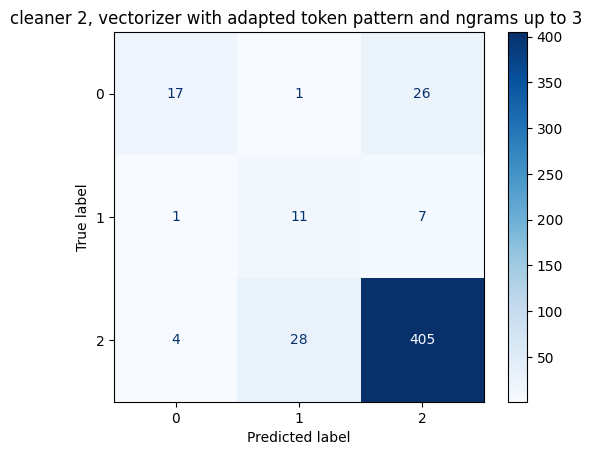

In [97]:
SVMopt(train_file, test_file, clean_text2, vectorizer5, "cleaner 2, vectorizer with adapted token pattern and ngrams up to 3 ")

              precision    recall  f1-score   support

           0       0.80      0.36      0.50        44
           1       0.33      0.68      0.45        19
           2       0.93      0.94      0.93       437

    accuracy                           0.88       500
   macro avg       0.69      0.66      0.63       500
weighted avg       0.90      0.88      0.88       500



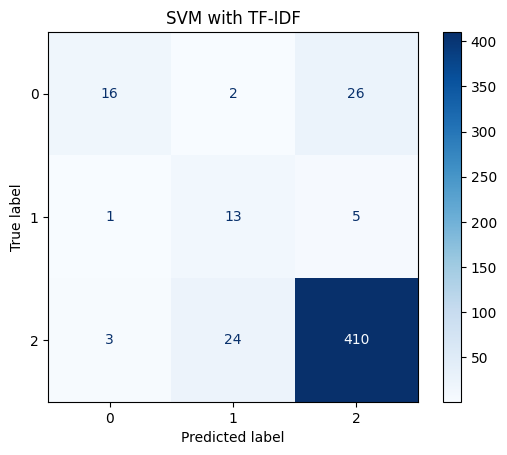

In [98]:
SVMopt(train_file, test_file, clean_text3, vectorizer3, "SVM with TF-IDF")

              precision    recall  f1-score   support

           0       0.80      0.36      0.50        44
           1       0.34      0.74      0.47        19
           2       0.93      0.94      0.93       437

    accuracy                           0.88       500
   macro avg       0.69      0.68      0.63       500
weighted avg       0.90      0.88      0.88       500



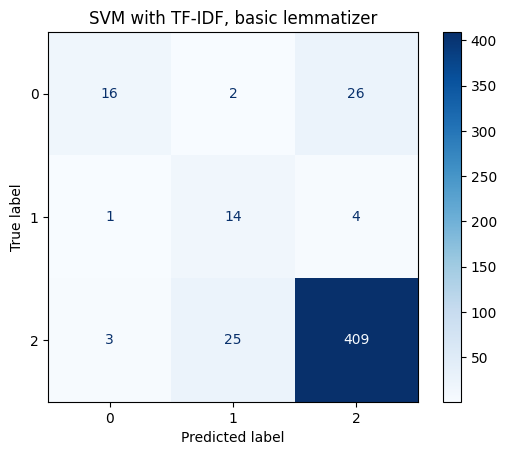

In [99]:
SVMopt(train_file, test_file, clean_text3, vectorizer3, "SVM with TF-IDF, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.81      0.39      0.52        44
           1       0.33      0.74      0.45        19
           2       0.93      0.93      0.93       437

    accuracy                           0.88       500
   macro avg       0.69      0.68      0.64       500
weighted avg       0.90      0.88      0.88       500



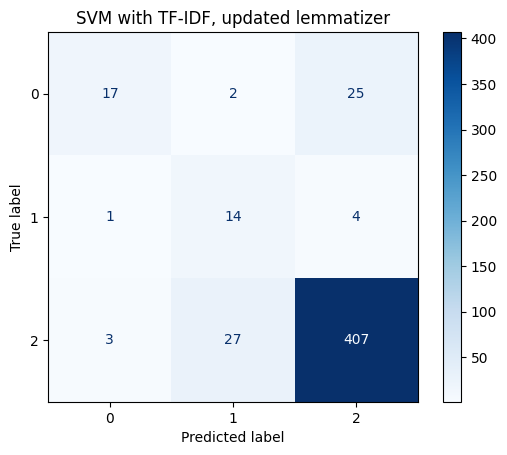

In [100]:
SVMopt(train_file, test_file, clean_text3, vectorizer3, "SVM with TF-IDF, updated lemmatizer", lemmatize_updated)

              precision    recall  f1-score   support

           0       0.78      0.41      0.54        44
           1       0.27      0.58      0.37        19
           2       0.93      0.92      0.93       437

    accuracy                           0.87       500
   macro avg       0.66      0.64      0.61       500
weighted avg       0.89      0.87      0.87       500



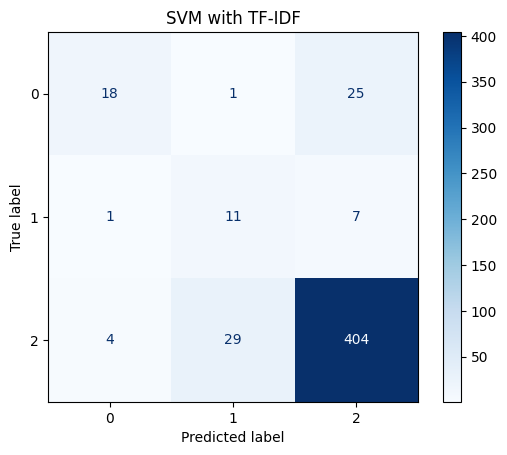

In [101]:
SVMopt(train_file, test_file, clean_text2, vectorizer4, "SVM with TF-IDF")

Random forest

              precision    recall  f1-score   support

           0       0.53      0.66      0.59        44
           1       0.22      0.79      0.34        19
           2       0.96      0.83      0.89       437

    accuracy                           0.81       500
   macro avg       0.57      0.76      0.61       500
weighted avg       0.90      0.81      0.84       500



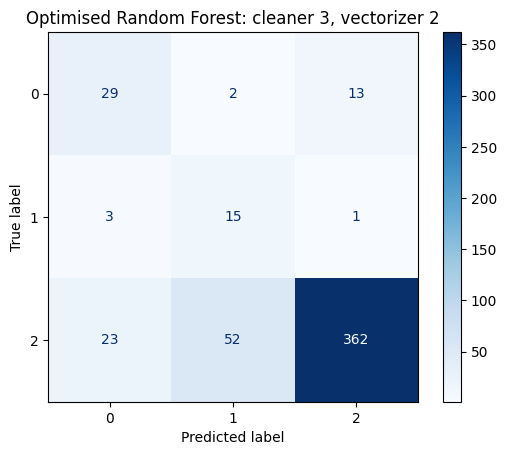

In [111]:
RF(train_file, test_file, clean_text3, vectorizer2, "Optimised Random Forest: cleaner 3, vectorizer 2")

              precision    recall  f1-score   support

           0       0.47      0.86      0.61        44
           1       0.20      0.79      0.32        19
           2       0.99      0.78      0.87       437

    accuracy                           0.79       500
   macro avg       0.55      0.81      0.60       500
weighted avg       0.91      0.79      0.83       500



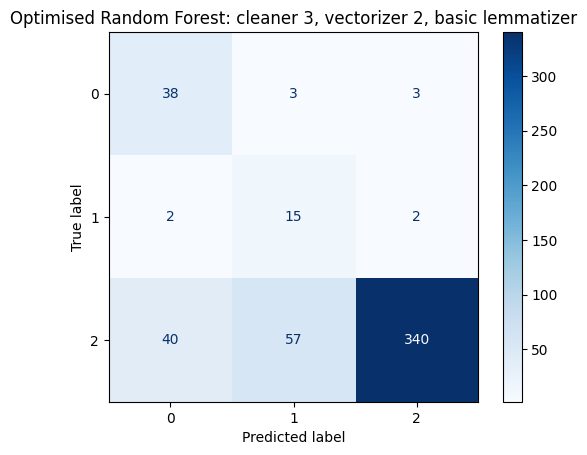

In [112]:
RF(train_file, test_file, clean_text3, vectorizer2, "Optimised Random Forest: cleaner 3, vectorizer 2, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.53      0.64      0.58        44
           1       0.21      0.79      0.33        19
           2       0.96      0.82      0.88       437

    accuracy                           0.80       500
   macro avg       0.56      0.75      0.60       500
weighted avg       0.89      0.80      0.83       500



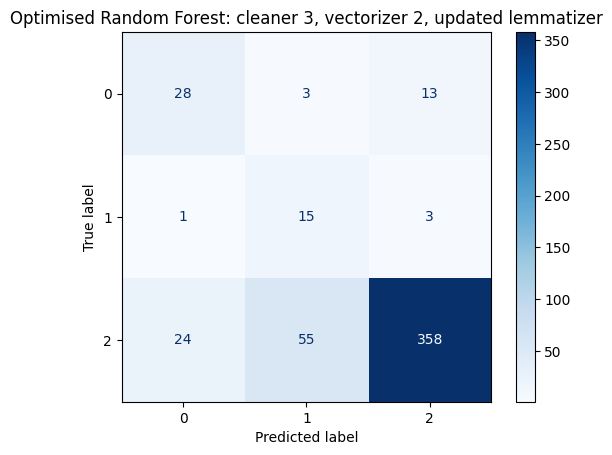

In [113]:
RF(train_file, test_file, clean_text3, vectorizer2, "Optimised Random Forest: cleaner 3, vectorizer 2, updated lemmatizer", lemmatize_updated)

Multimodal Naive Bayes

              precision    recall  f1-score   support

           0       0.88      0.48      0.62        44
           1       0.44      0.58      0.50        19
           2       0.94      0.97      0.95       437

    accuracy                           0.91       500
   macro avg       0.75      0.67      0.69       500
weighted avg       0.91      0.91      0.90       500



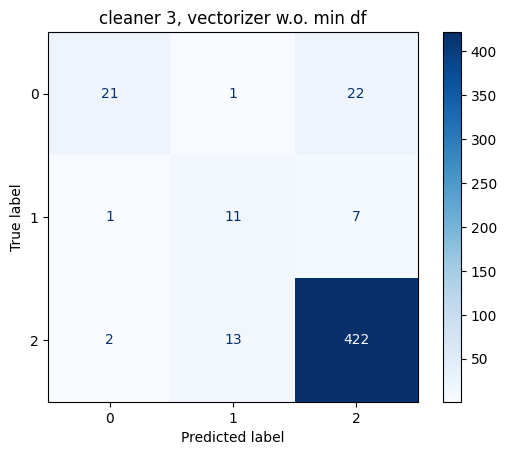

In [102]:
MNB(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

              precision    recall  f1-score   support

           0       0.88      0.48      0.62        44
           1       0.42      0.58      0.49        19
           2       0.94      0.96      0.95       437

    accuracy                           0.91       500
   macro avg       0.74      0.67      0.69       500
weighted avg       0.91      0.91      0.90       500



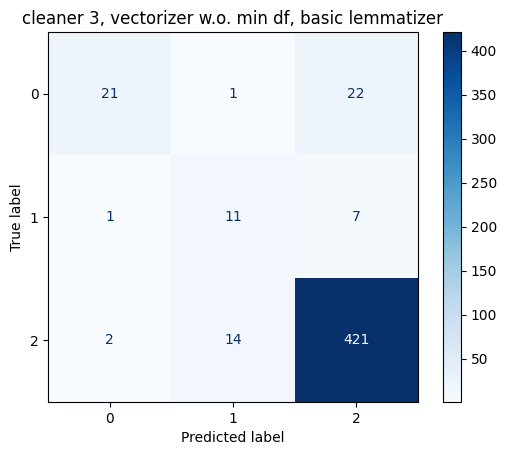

In [103]:
MNB(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.88      0.48      0.62        44
           1       0.41      0.58      0.48        19
           2       0.94      0.96      0.95       437

    accuracy                           0.90       500
   macro avg       0.74      0.67      0.68       500
weighted avg       0.91      0.90      0.90       500



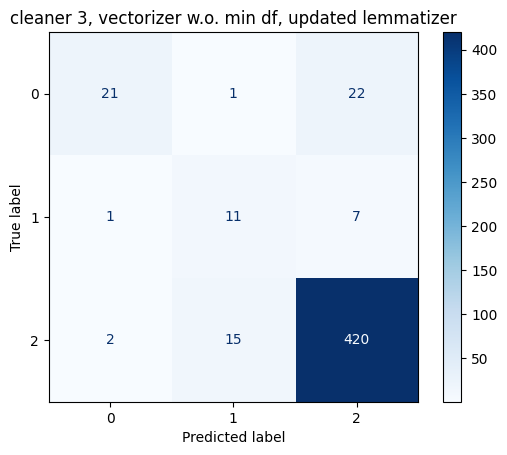

In [104]:
MNB(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer", lemmatize_updated)

Complement Naive Bayes

              precision    recall  f1-score   support

           0       0.64      0.89      0.74        44
           1       0.38      0.68      0.49        19
           2       0.98      0.91      0.94       437

    accuracy                           0.90       500
   macro avg       0.67      0.83      0.72       500
weighted avg       0.93      0.90      0.91       500



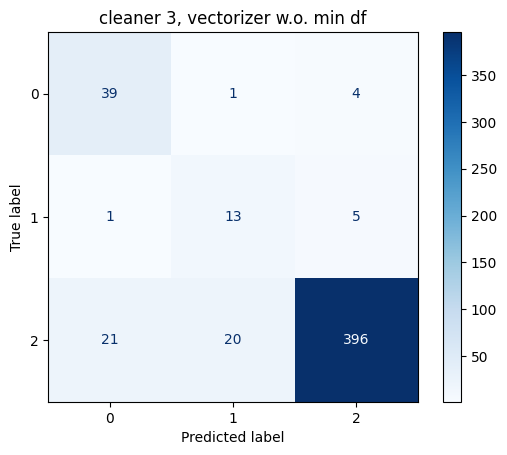

In [105]:
CNB(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df")

              precision    recall  f1-score   support

           0       0.64      0.89      0.74        44
           1       0.37      0.68      0.48        19
           2       0.98      0.90      0.94       437

    accuracy                           0.89       500
   macro avg       0.66      0.82      0.72       500
weighted avg       0.92      0.89      0.90       500



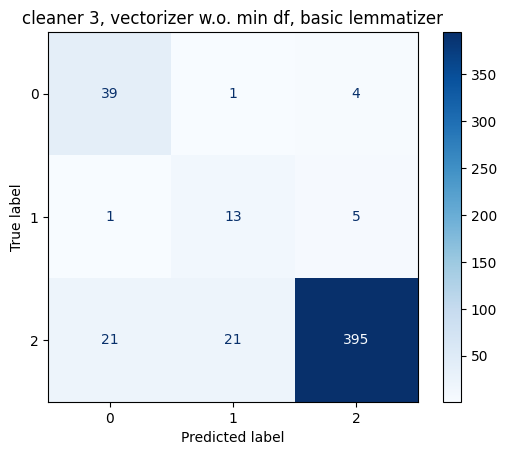

In [106]:
CNB(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, basic lemmatizer", lemmatize_bio_text)

              precision    recall  f1-score   support

           0       0.64      0.89      0.74        44
           1       0.35      0.68      0.46        19
           2       0.98      0.90      0.94       437

    accuracy                           0.89       500
   macro avg       0.66      0.82      0.71       500
weighted avg       0.92      0.89      0.90       500



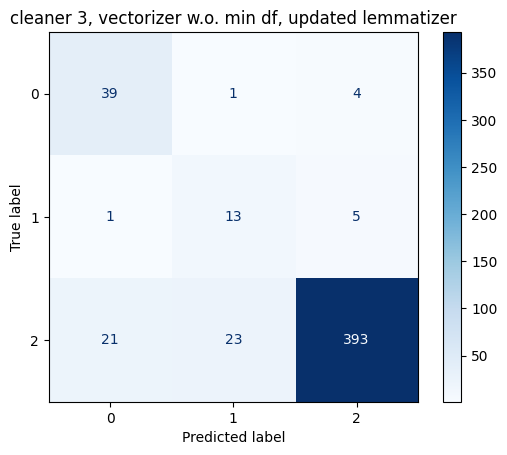

In [107]:
CNB(train_file, test_file, clean_text3, vectorizer2, "cleaner 3, vectorizer w.o. min df, updated lemmatizer", lemmatize_updated)